In [ ]:
!pip install torchvision
!pip install wandb

### Dependencies

In [37]:
import torch
from torch import nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda import amp
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from PIL import Image

# from models import Generator, Discriminator
import gc

from tqdm import tqdm
import os
import random
import sys
import time
import copy
from collections import defaultdict

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

### Login to Weights & Biases

In [38]:
import wandb

API_KEY = "5156658a1eec69dd17b8fada84a91056f96da322"

wandb.login(key=API_KEY)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/hghallab/.netrc


True

In [97]:
class CFG:
    seed          = 42
    debug         = False
    model_name    = 'DCGAN|FirstGan'
    loss_function = 'BCELoss'
    train_bs      = 8
    valid_bs      = 8
    # img_size      = [720, 1280]
    # input_size    = [736, 1280]
    epochs        = 20
    lr            = 2e-4
    n_accumulate  = max(1, 32//train_bs)
    # num_classes   = 1
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
print(CFG.device)

cpu


In [41]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


### Data Loading


In [42]:
data_dir = "/home/hghallab/dataset/GANs_dataset/FirstGan"

In [63]:
# Define the transform 
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((1000, 1000)),
    # torchvision.transforms.Normalize((0.5,), (0.5,))
])

In [64]:
# torchvision.io.read_image
def load_img(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.transpose(img, (2, 0, 1))
    img = torch.Tensor(img)
    return img

In [65]:
class ganData(torch.utils.data.Dataset):
    def __init__(self, transform=transform, data_dir=data_dir):
        self.data_dir = data_dir
        self.transform = transform
        self.images_path = data_dir
        self.images = os.listdir(self.images_path)
    
    def __len__(self):
        return len(os.listdir(self.images_path))
    
    def __getitem__(self, idx):
        item_name = self.images[idx]
        img = load_img(os.path.join(self.images_path, item_name))
        img = self.transform(img)
        # img = Image.fromarray(img)
        return img

In [93]:
dataset = ganData()

if CFG.debug:
    train_data, valid_data, _ = torch.utils.data.random_split(dataset, [0.1, 0.1, 0.8])
else:
    train_data, valid_data = torch.utils.data.random_split(dataset, [1, 0])


train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_bs, num_workers=0, shuffle=True, pin_memory=True, drop_last=False) # num_workers=0 for debugging else 4
# valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=CFG.valid_bs, num_workers=0, shuffle=False, pin_memory=True) # num_workers=0 for debugging else 4


/home/hghallab/.local/lib/python3.10/site-packages/torch/utils/data/dataset.py:449: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [94]:
next(iter(valid_loader))

tensor([[[[182.2649, 180.4649, 181.5141,  ...,   1.0000,   0.2800,   0.0000],
          [183.4415, 181.6415, 182.1614,  ...,   1.0000,   0.2800,   0.0000],
          [184.6180, 182.8181, 183.3380,  ...,   1.0000,   0.2800,   0.0000],
          ...,
          [121.4914, 127.1997, 128.2711,  ...,  30.7820,  30.8269,  31.0000],
          [117.9911, 124.1645, 126.7204,  ...,  31.4000,  31.0000,  31.0000],
          [116.2116, 120.1347, 122.8854,  ...,  30.6649,  30.7942,  31.3851]],

         [[195.2649, 193.4649, 194.5142,  ...,   3.0000,   2.2800,   1.4762],
          [196.4415, 194.6415, 195.1615,  ...,   3.0000,   2.2800,   1.4762],
          [197.6180, 195.8181, 196.3380,  ...,   3.0000,   2.2800,   1.4762],
          ...,
          [ 90.4914,  96.1997,  97.2711,  ...,  24.1820,  24.8269,  25.0000],
          [ 86.9911,  93.1645,  95.7204,  ...,  24.8000,  25.0000,  25.0000],
          [ 85.2116,  89.1347,  91.8854,  ...,  24.0649,  24.7942,  25.3851]],

         [[212.2649, 210.4649,

In [82]:
def visualize_item(image, gt=None, pred=None):
    image_np = image.cpu().numpy() if image.is_cuda else image.numpy()
    image_np = image_np.squeeze()
    image_np = np.transpose(image_np, (1, 2, 0)).astype("uint8")
    plt.axis('off')
    plt.imshow(image_np)
    plt.show()

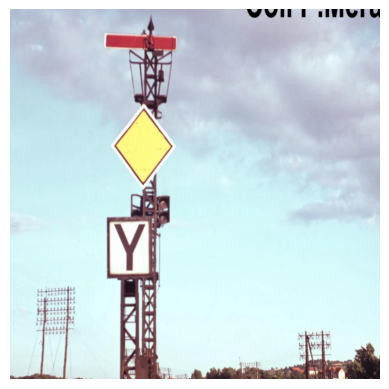

In [85]:
for img in next(iter(valid_loader)):
    visualize_item(img)
    break

### Model 

Definition of Generator and Discriminator. 



In [86]:
class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

In [95]:
    
generator = Generator()
discriminator = Discriminator()

device = torch.device(CFG.device)
generator = generator.to(device)
discriminator = discriminator.to(device)

num_params_gen = sum(p.numel() for p in generator.parameters() if p.requires_grad)
num_params_disc = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print('Number of parameters for generator: %d and discriminator: %d' % (num_params_gen, num_params_disc))

Number of parameters for generator: 12660355 and discriminator: 11038081


In [90]:
print(generator)
print(discriminator)

Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(

### Training

In [98]:
MODEL_WORKSPACE = "/home/hghallab/Dvlp/GANs/DCGAN"
os.chdir(MODEL_WORKSPACE)
runs = sorted(os.listdir(os.path.join(MODEL_WORKSPACE, "runs")))
if len(runs) == 0:
    CURRENT_MODEL_DIR = "runs/" + "run_1"
else:
    CURRENT_MODEL_DIR = "runs/" + f"run_{int(runs[-1].split('_')[-1]) + 1}"
os.mkdir(os.path.join(MODEL_WORKSPACE, CURRENT_MODEL_DIR))

In [96]:
gen_optimizer = torch.optim.Adam(params=generator.parameters(), lr=CFG.lr, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(params=discriminator.parameters(), lr=CFG.lr, betas=(0.5, 0.999))

criterion = torch.nn.BCELoss()

In [ ]:
# set to training mode
generator.train()
discriminator.train()

gen_loss_avg = []
disc_loss_avg = []

print('Training ...')

wandb.watch(generator, log_freq=100)
wandb.watch(discriminator, log_freq=100)

start = time.time()

best_model_gen = copy.deepcopy(generator.state_dict())
best_model_disc = copy.deepcopy(discriminator.state_dict())
best_epoch     = -1
best_disc_loss = np.inf
best_gen_loss = np.inf
history = defaultdict(list)

run = wandb.init(project='DCGAN', 
                config={k:v for k, v in dict(vars(CFG)).items() if '__' not in k},
                name=f"{CURRENT_MODEL_DIR}|model-{CFG.model_name}",
                )

for epoch in range(CFG.epochs):
    gen_loss_avg.append(0)
    disc_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_loader:
        
        # get dataset image and create real and fake labels for use in the loss
        image_batch = image_batch.to(device)
        label_real = torch.ones(image_batch.size(0), device=device)
        label_fake = torch.zeros(image_batch.size(0), device=device)

        # generate a batch of images from samples of the latent prior
        latent = torch.randn(image_batch.size(0), 100, 1, 1, device=device)
        fake_image_batch = generator(latent)
        
        # train discriminator to correctly classify real and fake
        # (detach the computation graph of the generator and the discriminator,
        # so that gradients are not backpropagated into the generator)
        real_pred = discriminator(image_batch).squeeze()
        fake_pred = discriminator(fake_image_batch.detach()).squeeze()
        disc_loss = 0.5 * (
            F.binary_cross_entropy(real_pred, label_real) +
            F.binary_cross_entropy(fake_pred, label_fake))
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # train generator to output an image that is classified as real
        fake_pred = discriminator(fake_image_batch).squeeze()
        gen_loss = F.binary_cross_entropy(fake_pred, label_real)
        
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()
        
        gen_loss_avg[-1] += gen_loss.item()
        disc_loss_avg[-1] += disc_loss.item()
        num_batches += 1

        
    gen_loss_avg[-1] /= num_batches
    disc_loss_avg[-1] /= num_batches

    
    # deep copy the model
    if disc_loss_avg[-1] >= best_disc_loss:
        print(f"{c_}Valid Score Improved ({best_disc_loss:0.4f} ---> {disc_loss_avg[-1]:0.4f})")
        best_disc_loss   = disc_loss_avg[-1]
        best_epoch   = epoch
        run.summary["Best Disriminator Loss"]    = best_disc_loss
        run.summary["Corresponding Generator Loss"] = gen_loss_avg[-1] 
        run.summary["Best Epoch"]   = best_epoch
        best_model_gen = copy.deepcopy(generator.state_dict())
        best_model_disc = copy.deepcopy(discriminator.state_dict())
        # PATH = f"best_epoch-{fold:02d}.bin"
        PATH = f"{CURRENT_MODEL_DIR}/best_epoch.bin"
        torch.save(generator.state_dict(), PATH)
        torch.save(discriminator.state_dict(), PATH)        
        # Save a model file from the current directory
        wandb.save(PATH)
        print(f"Model Saved{sr_}")
    
    # Log the metrics
    wandb.log({"Discriminator Loss": disc_loss_avg[-1], 
               "Generator Loss": gen_loss_avg[-1],})
    
    print('Epoch [%d / %d] average loss generator vs. discrim.: %f vs. %f' %
          (epoch+1, CFG.epochs, gen_loss_avg[-1], disc_loss_avg[-1]))

    
history['Discriminator Loss'] = disc_loss_avg
history['Generator Loss'] = gen_loss_avg

    
end = time.time()
time_elapsed = end - start
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
print("Best Score: {:.4f}".format(best_disc_loss))

run.finish()
